# Libs, data importing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from datetime import date
from joblib import dump, load

# Configuration
# ==============================================================================
import warnings
import holidays
warnings.filterwarnings('ignore')



/home/jerzy/.conda/envs/indml/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/home/jerzy/.conda/envs/indml/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data_train = pd.read_csv('/home/jerzy/Documents/IndustrialML/data/train_preprocessed.csv')
data_train.drop('Unnamed: 0', axis=1, inplace=True)
data_train

,point,lon,lat,time,timestamp,num_posts
0,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-22 11:00:00,1574420400,1
1,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-22 12:00:00,1574424000,1
2,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-23 13:00:00,1574514000,1
3,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-25 16:00:00,1574697600,1
4,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-27 10:00:00,1574848800,1
...,...,...,...,...,...,...
3625651,0101000020E6100000FF9D4C0EC3853E4094782B2D0DF3...,30.522508,59.898840,2019-12-06 04:00:00,3151209600,2
3625652,0101000020E6100000FF9D4C0EC3853E4094782B2D0DF3...,30.522508,59.898840,2019-12-23 08:00:00,1577088000,1
3625653,0101000020E6100000FF9D4C0EC3853E40ABD94A1972EF...,30.522508,59.870670,2019-06-10 09:00:00,1560157200,1
3625654,0101000020E6100000FF9D4C0EC3853E40ABD94A1972EF...,30.522508,59.870670,2019-10-06 14:00:00,1570370400,1


In [3]:
data_test = pd.read_csv('/home/jerzy/Documents/IndustrialML/data/test.csv')
data_test

,hour,lat,lon,point,sum,error
0,1582711200,59.934863,30.331616,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,7,0.370265
1,1581937200,59.940488,30.329370,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,6,0.754735
2,1581523200,59.905597,30.297929,0101000020E61000006AEBE80E454C3E407F614299EAF3...,5,3.754735
3,1581512400,59.921359,30.356319,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,16,4.088069
4,1581771600,59.939363,30.315895,0101000020E61000006141807FDE503E40A554BF083DF8...,10,2.088069
...,...,...,...,...,...,...
695,1582059600,59.926986,30.331616,0101000020E61000009BAC04C2E4543E4070B5CC78A7F6...,6,0.754735
696,1582038000,59.925860,30.295683,0101000020E6100000AB00D6E0B14B3E406379569882F6...,15,1.215399
697,1581926400,59.937113,30.282208,0101000020E6100000328064CC3E483E400C288C4EF3F7...,20,18.754735
698,1582099200,59.933737,30.322632,0101000020E61000009E01B90998523E407AB3D8B484F7...,8,2.754735


In [4]:
data_val = pd.read_csv('/home/jerzy/Documents/IndustrialML/data/valid.csv')
data_val

,hour,lat,lon,point,sum,error
0,1582448400,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402
1,1582225200,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291
2,1581260400,60.002300,30.295683,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735
3,1581958800,59.935988,30.324878,0101000020E61000005DECCB372B533E40E4A1F770CEF7...,7,0.504735
4,1582779600,59.933737,30.306912,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.554735
...,...,...,...,...,...,...
704,1580659200,59.905597,30.297929,0101000020E61000006AEBE80E454C3E407F614299EAF3...,7,2.254735
705,1581048000,59.950610,30.315895,0101000020E61000006141807FDE503E402B348A98ADF9...,8,6.754735
706,1581656400,59.933737,30.309158,0101000020E6100000268147F5244F3E407AB3D8B484F7...,6,4.754735
707,1580724000,59.931487,30.358565,0101000020E61000008EADE7EACA5B3E40CAE971F73AF7...,8,1.421402


In [5]:
data_unique_points = data_train['point'].unique()
test_unique_points = data_test['point'].unique()
valid_unique_points = data_val['point'].unique()

# Split data into year, month, day, hour and adding holidays, weekends, weekdays

Add datetime column to test and valid datasets

In [6]:
data_test['datetime'] = pd.to_datetime(data_test['hour'], unit='s')
data_val['datetime'] = pd.to_datetime(data_val['hour'], unit='s')
data_train['datetime'] = pd.to_datetime(data_train['time'])

In [7]:
data_train

,point,lon,lat,time,timestamp,num_posts,datetime
0,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-22 11:00:00,1574420400,1,2019-11-22 11:00:00
1,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-22 12:00:00,1574424000,1,2019-11-22 12:00:00
2,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-23 13:00:00,1574514000,1,2019-11-23 13:00:00
3,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-25 16:00:00,1574697600,1,2019-11-25 16:00:00
4,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-27 10:00:00,1574848800,1,2019-11-27 10:00:00
...,...,...,...,...,...,...,...
3625651,0101000020E6100000FF9D4C0EC3853E4094782B2D0DF3...,30.522508,59.898840,2019-12-06 04:00:00,3151209600,2,2019-12-06 04:00:00
3625652,0101000020E6100000FF9D4C0EC3853E4094782B2D0DF3...,30.522508,59.898840,2019-12-23 08:00:00,1577088000,1,2019-12-23 08:00:00
3625653,0101000020E6100000FF9D4C0EC3853E40ABD94A1972EF...,30.522508,59.870670,2019-06-10 09:00:00,1560157200,1,2019-06-10 09:00:00
3625654,0101000020E6100000FF9D4C0EC3853E40ABD94A1972EF...,30.522508,59.870670,2019-10-06 14:00:00,1570370400,1,2019-10-06 14:00:00


Add yyyy, mm, dd, hh to test and valid

In [8]:
data_train["year"] = data_train["datetime"].dt.year
data_train["month"] = data_train["datetime"].dt.month
data_train["day"] = data_train["datetime"].dt.day
data_train["hour"] = data_train["datetime"].dt.hour
data_train["weekday"] = data_train["datetime"].dt.weekday

data_test["year"] = data_test["datetime"].dt.year
data_test["month"] = data_test["datetime"].dt.month
data_test["day"] = data_test["datetime"].dt.day
data_test["hour"] = data_test["datetime"].dt.hour
data_test["weekday"] = data_test["datetime"].dt.weekday

data_val["year"] = data_val["datetime"].dt.year
data_val["month"] = data_val["datetime"].dt.month
data_val["day"] = data_val["datetime"].dt.day
data_val["hour"] = data_val["datetime"].dt.hour
data_val["weekday"] = data_val["datetime"].dt.weekday

Add holidays

In [9]:
holidays_russia = holidays.country_holidays('RU', years = [2019, 2020])

data_train['is_holiday'] = data_train['datetime'].apply(lambda x: 1 if x in holidays_russia else 0)
data_test['is_holiday'] = data_test['datetime'].apply(lambda x: 1 if x in holidays_russia else 0)
data_val['is_holiday'] = data_val['datetime'].apply(lambda x: 1 if x in holidays_russia else 0)

In [10]:
data_train = data_train.drop(['time'], axis=1)

# Regressions: catboost, lightgbm and xgboost

In [11]:
# fig, ax = plt.subplots(figsize=(11, 4))

# data_train[data_train['point'] == '0101000020E6100000DBC1F19351543E4006FC5DE561F84D40']['num_posts'].plot(ax=ax, label='train')
# data_val[data_val['point'] == '0101000020E6100000DBC1F19351543E4006FC5DE561F84D40']['sum'].plot(ax=ax, label='validation')
# data_test[data_test['point'] == '0101000020E6100000DBC1F19351543E4006FC5DE561F84D40']['sum'].plot(ax=ax, label='test')
# ax.set_title('Number of users')
# ax.legend();

In [37]:
# Mutual information matrix
# =================================================================================
from sklearn.metrics import mutual_info_score

def mutual_info_matrix(data):
    mi_matrix = pd.DataFrame(index=data.columns, columns=data.columns)
    for i in data.columns:
        for j in data.columns:
            mi_matrix.loc[i, j] = round(float(mutual_info_score(data[i], data[j])), 2)
    return mi_matrix

mi_train = mutual_info_matrix(data_train)

# convert all columns to float 
mi_train = mi_train.astype(float)

<AxesSubplot:>

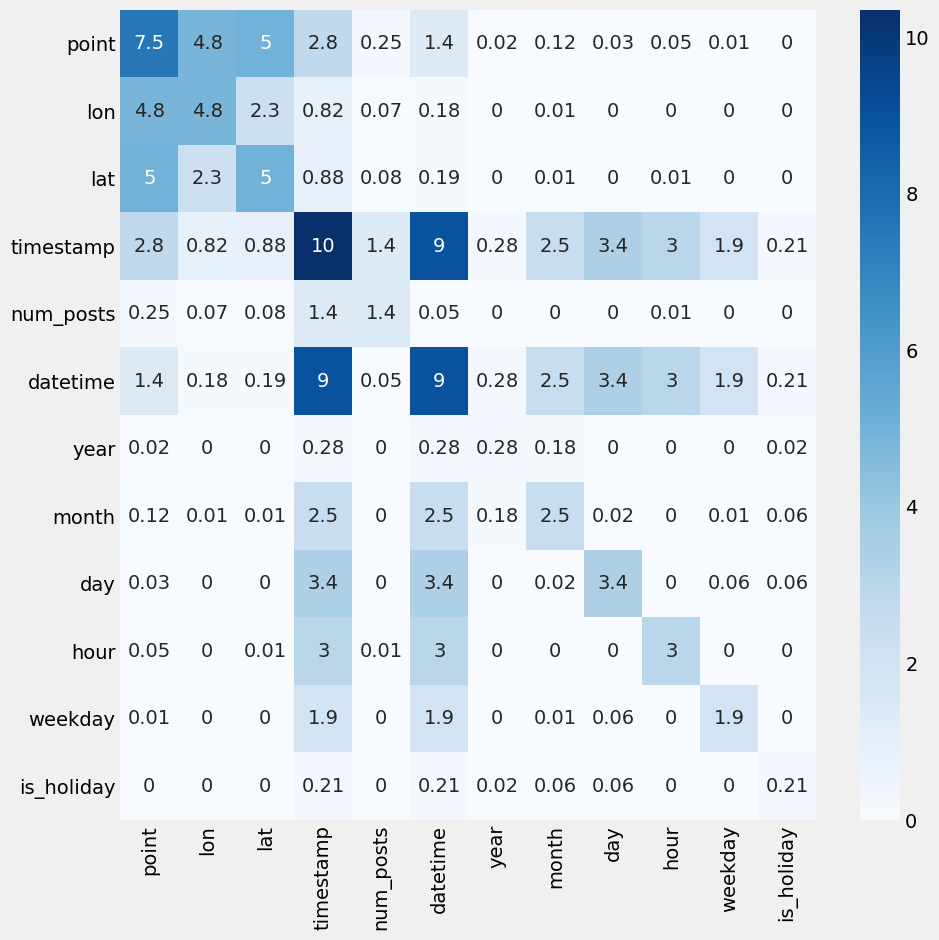

In [40]:
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(mi_train, annot=True, cmap='Blues')

## XGBoost

In [13]:
def custom_metric(y_true, y_pred):
    return abs(y_true - y_pred) / y_true

### test data

In [14]:
%%time

data_test_xgboost_error = []

for point in test_unique_points:
    xg_model = XGBRegressor()
    data_train_point = data_train[data_train['point'] == point]
    data_test_point = data_test[data_test['point'] == point]
    X_train = data_train_point[['timestamp', 'year', 'month', 'day', 'hour', 'weekday', 'is_holiday']]
    y_train = data_train_point['num_posts']
    xg_model.fit(X_train, y_train)
    data_test_point['xgboost'] = np.round(xg_model.predict(data_test_point[['hour', 'year', 'month', 'day', 'hour', 'weekday', 'is_holiday']].values))
    data_test_point['xgboost_error'] = custom_metric(data_test_point['sum'], data_test_point['xgboost'])
    data_test_xgboost_error.append(list(data_test_point['xgboost_error']))


CPU times: user 4min 36s, sys: 552 ms, total: 4min 37s
Wall time: 36.7 s


In [15]:
def flatten(l):
    return [item for sublist in l for item in sublist]

data_test_xgboost_error = flatten(data_test_xgboost_error)

In [16]:
data_test['xgboost_error'] = data_test_xgboost_error

In [17]:
data_test

,hour,lat,lon,point,sum,error,datetime,year,month,day,weekday,is_holiday,xgboost_error
0,10,59.934863,30.331616,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,7,0.370265,2020-02-26 10:00:00,2020,2,26,2,0,0.857143
1,11,59.940488,30.329370,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,6,0.754735,2020-02-17 11:00:00,2020,2,17,0,0,0.833333
2,16,59.905597,30.297929,0101000020E61000006AEBE80E454C3E407F614299EAF3...,5,3.754735,2020-02-12 16:00:00,2020,2,12,2,0,0.800000
3,13,59.921359,30.356319,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,16,4.088069,2020-02-12 13:00:00,2020,2,12,2,0,0.800000
4,13,59.939363,30.315895,0101000020E61000006141807FDE503E40A554BF083DF8...,10,2.088069,2020-02-15 13:00:00,2020,2,15,5,0,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,21,59.926986,30.331616,0101000020E61000009BAC04C2E4543E4070B5CC78A7F6...,6,0.754735,2020-02-18 21:00:00,2020,2,18,1,0,0.800000
696,15,59.925860,30.295683,0101000020E6100000AB00D6E0B14B3E406379569882F6...,15,1.215399,2020-02-18 15:00:00,2020,2,18,1,0,0.833333
697,8,59.937113,30.282208,0101000020E6100000328064CC3E483E400C288C4EF3F7...,20,18.754735,2020-02-17 08:00:00,2020,2,17,0,0,0.857143
698,8,59.933737,30.322632,0101000020E61000009E01B90998523E407AB3D8B484F7...,8,2.754735,2020-02-19 08:00:00,2020,2,19,2,0,0.800000


In [18]:
data_test['xgboost_error'].mean()

0.8662030853982366

In [19]:
%%time

data_val_xgboost_error = []

for point in valid_unique_points:
    xg_model = XGBRegressor()
    data_train_point = data_train[data_train['point'] == point]
    data_val_point = data_val[data_val['point'] == point]
    print(data_val_point)
    X_train = data_train_point[['timestamp', 'year', 'month', 'day', 'hour', 'weekday', 'is_holiday']]
    y_train = data_train_point['num_posts']
    xg_model.fit(X_train, y_train)
    data_val_point['xgboost'] = np.round(xg_model.predict(data_val_point[['hour', 'year', 'month', 'day', 'hour', 'weekday', 'is_holiday']].values))
    data_val_point['xgboost_error'] = custom_metric(data_val_point['sum'], data_val_point['xgboost'])
    data_val_xgboost_error.append(list(data_val_point['xgboost_error']))

     hour        lat        lon  \
0       9  59.926986  30.318141   
136    12  59.926986  30.318141   
167    11  59.926986  30.318141   
274    20  59.926986  30.318141   
435    10  59.926986  30.318141   
476     8  59.926986  30.318141   
512    14  59.926986  30.318141   
580    19  59.926986  30.318141   

                                                 point  sum     error  \
0    0101000020E6100000202C93AD71513E4070B5CC78A7F6...    5  0.421402   
136  0101000020E6100000202C93AD71513E4070B5CC78A7F6...    5  0.530979   
167  0101000020E6100000202C93AD71513E4070B5CC78A7F6...    6  1.754735   
274  0101000020E6100000202C93AD71513E4070B5CC78A7F6...    8  6.754735   
435  0101000020E6100000202C93AD71513E4070B5CC78A7F6...   11  4.254735   
476  0101000020E6100000202C93AD71513E4070B5CC78A7F6...    7  5.754735   
512  0101000020E6100000202C93AD71513E4070B5CC78A7F6...    6  1.754735   
580  0101000020E6100000202C93AD71513E4070B5CC78A7F6...    7  0.504735   

               datetime  y

KeyError: "['weekend'] not in index"

In [ ]:
data_val_xgboost_error = flatten(data_val_xgboost_error)

In [ ]:
data_val['xgboost_error'] = data_val_xgboost_error
data_val['xgboost_error'].mean()

0.8730933603179748

## CatBoost 

In [ ]:
# 

In [ ]:
%%time

data_test_catboost_error = []

for point in test_unique_points:
    cat_model = CatBoostRegressor()
    data_train_point = data_train[data_train['point'] == point]
    data_test_point = data_test[data_test['point'] == point]
    X_train = data_train_point['timestamp']
    y_train = data_train_point['num_posts']
    cat_model.fit(X_train.values.reshape(-1, 1), y_train)
    data_test_point['catboost'] = np.round(cat_model.predict(data_test_point['hour'].values.reshape(-1, 1)))
    data_test_point['catboost_error'] = custom_metric(data_test_point['sum'], data_test_point['catboost'])
    data_test_catboost_error.append(list(data_test_point['catboost_error']))

In [ ]:
data_test_catboost_error = flatten(data_test_catboost_error)
data_test['catboost_error'] = data_test_catboost_error
data_test

In [ ]:
data_test['catboost_error'].mean()

In [ ]:
%%time
data_val_catboost_error = []

for point in valid_unique_points:
    cat_model = CatBoostRegressor()
    data_train_point = data_train[data_train['point'] == point]
    data_val_point = data_val[data_val['point'] == point]
    X_train = data_train_point['timestamp']
    y_train = data_train_point['num_posts']
    cat_model.fit(X_train.values.reshape(-1, 1), y_train)
    data_val_point['catboost'] = np.round(cat_model.predict(data_val_point['hour'].values.reshape(-1, 1)))
    data_val_point['catboost_error'] = custom_metric(data_val_point['sum'], data_val_point['catboost'])
    data_val_catboost_error.append(list(data_val_point['catboost_error']))

data_val_catboost_error = flatten(data_val_catboost_error)
data_val['catboost_error'] = data_val_catboost_error
data_val['catboost_error'].mean()

In [ ]:
%%time

data_test_lgdmboost_error = []

for point in test_unique_points:
    lgdm_model = LGBMRegressor()
    data_train_point = data_train[data_train['point'] == point]
    data_test_point = data_test[data_test['point'] == point]
    X_train = data_train_point['timestamp']
    y_train = data_train_point['num_posts']
    lgdm_model.fit(X_train.values.reshape(-1, 1), y_train)
    data_test_point['lgdmboost'] = np.round(lgdm_model.predict(data_test_point['hour'].values.reshape(-1, 1)))
    data_test_point['lgdmboost_error'] = custom_metric(data_test_point['sum'], data_test_point['lgdmboost'])
    data_test_lgdmboost_error.append(list(data_test_point['lgdmboost_error']))

data_test_lgdmboost_error = flatten(data_test_lgdmboost_error)
data_test['lgdmboost_error'] = data_test_lgdmboost_error
data_test

In [ ]:
data_test['lgdmboost_error'].mean()

In [ ]:
%%time
data_val_lgdmboost_error = []

for point in valid_unique_points:
    cat_model = CatBoostRegressor()
    data_train_point = data_train[data_train['point'] == point]
    data_val_point = data_val[data_val['point'] == point]
    X_train = data_train_point['timestamp']
    y_train = data_train_point['num_posts']
    lgdm_model.fit(X_train.values.reshape(-1, 1), y_train)
    data_val_point['lgdmboost'] = np.round(lgdm_model.predict(data_val_point['hour'].values.reshape(-1, 1)))
    data_val_point['lgdmboost_error'] = custom_metric(data_val_point['sum'], data_val_point['lgdmboost'])
    data_val_lgdmboost_error.append(list(data_val_point['lgdmboost_error']))

data_val_lgdmboost_error = flatten(data_val_lgdmboost_error)
data_val['lgdmboost_error'] = data_val_lgdmboost_error
data_val['lgdmboost_error'].mean()